# Определение "токсичных" комментариев

Заказчик проекта — интернет-магазин "Викишоп". Магазин планирует запуск нового сервиса, где пользователи смогут редактировать и добавлять описание товаров, как в вики-сообществах. 

Цель проекта — создать модель, которая сможет выявить "токсичные" комментарии, которые следует отправить на модерацию.

В ходе работы мы загрузим и предобработаем данные. Затем обучим несколько разных моделей, и по результатам их работы выявим наилучшую по целевой метрике качества — F1. Её значение должно быть не менее 0.75 по условиям заказчика. Работа лучшей модели будет проверена на тестовой выборке.

## Подготовка данных

### Импорт библиотек

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


import re
import nltk
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('averaged_perceptron_tagger')



from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

from sklearn.metrics import f1_score

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


### Загрузка данных

In [2]:
data = pd.read_csv('/datasets/toxic_comments.csv')

In [3]:
data.head(10)

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0
5,5,"""\n\nCongratulations from me as well, use the ...",0
6,6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,7,Your vandalism to the Matt Shirvington article...,0
8,8,Sorry if the word 'nonsense' was offensive to ...,0
9,9,alignment on this subject and which are contra...,0


В датасете присутствует столбец `Unnamed: 0`, в котором дублируется индексация, — прежде чем продолжить, избавимся от него.

In [4]:
data = data.drop(columns=['Unnamed: 0'])

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


После преобразования в датасете осталось два столбца:
- `text` — содержит англоязычный текст комментария;
- `toxic` — оценка, является ли комментарий "токсичным", нуждающимся в модерации — **целевой** признак.

### Баланс классов

Прежде, чем перейти к обучению моделей, проверим баланс классов в датасете.

In [6]:
data['toxic'].value_counts()                                           # общее количество объектов каждого класса

0    143106
1     16186
Name: toxic, dtype: int64

<AxesSubplot:>

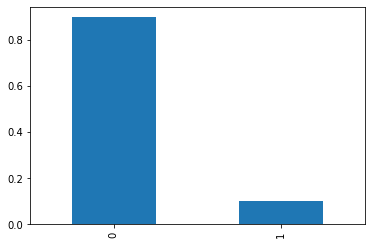

In [7]:
class_frequency = data['toxic'].value_counts(normalize=True)           # посмотрим на графике        
class_frequency.plot(kind='bar')

In [8]:
data['toxic'].value_counts()[0] / data['toxic'].value_counts()[1]

8.841344371679229

Как и ожидалось, имеется дисбаланс классов — на один токсичный комментарий приходится 8.84 обычных — все-таки большинство пользователей "адекватные" и пишут нормальные комментарии. Дисбаланс нужно будет учесть при обучении моделей.

Взглянем на несколько токсичных комментариев:

In [10]:
data[data['toxic']==1].sample(10)

,text,toxic
152498,SimCopter Shenanigans\nHiya. I originally foll...,1
152741,Idiocracy \n\nIf you need a 13 section FAQ to ...,1
29219,Perhaps there's a wikipedia for adults somewhe...,1
102057,"""\n\n Idiot! \n\nQuick! Lock your talk page!...",1
140134,"Oh, did little mrs. pussy get his feelings hur...",1
105392,A bunch of non-academic clowns are now censori...,1
137637,a complete tosser. I need to get a girlfriend ...,1
38529,Who the fuck are you!? Stay the fuck away from...,1
85470,"You absolute spastic\n\nI am right, Username72...",1
53615,Are you kidding me? \n\nAre you fucking stupid...,1


Если в комментарии есть `fuck` или `ass` его нужно увидеть модераторам. Именно такие слова и будут сигналом для модели.

## Обучение моделей

### Подготовка признаков

#### Лемматизация текстов

Для обучения модели тексты в датасете сначала следует привести к начальной форме — лемме. 

In [12]:
lemmatizer = WordNetLemmatizer() # создаем объект 

In [32]:
lemmatizer.lemmatize("bats")     # проверка работы на английском слове

'bat'

Для работы  лемматизатора нам понадобятся POS-теги (part-of-speech) — указатели, которые позволят правильно определить лемму слова.

Определим функцию, которая вернет POS-тег для слова:

In [24]:
def get_wordnet_pos(word):
    
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

In [29]:
def lemmatize_text(text, r_mask = r'[^a-zA-Z]'):
    """
    Данная функция принимает на вход текст и лемматизирует его.
    
    Перед лемматизацией текст будет приведет к нижнему регистру.
   
    Ожидается англоязычный текст — если использован другой язык, необходимо переопределить параметр функции r_mask
    """
    text = text.lower()
    
    lemm_text = " ".join(lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(text))
    
    cleared_text = re.sub(r_mask, ' ', lemm_text)
    
    return " ".join(cleared_text.split( ))

In [31]:
%%time

data['lemm_text'] = data['text'].apply(lemmatize_text)

CPU times: user 19min 23s, sys: 1min 54s, total: 21min 18s
Wall time: 21min 20s


In [33]:
data['text'].head(5)         # тексты до лемматизации

0    Explanation\nWhy the edits made under my usern...
1    D'aww! He matches this background colour I'm s...
2    Hey man, I'm really not trying to edit war. It...
3    "\nMore\nI can't make any real suggestions on ...
4    You, sir, are my hero. Any chance you remember...
Name: text, dtype: object

In [34]:
data['lemm_text'].head(5)    # тексты после лемматизации

0    explanation why the edits make under my userna...
1    d aww he match this background colour i m seem...
2    hey man i m really not try to edit war it s ju...
3    more i ca n t make any real suggestion on impr...
4    you sir be my hero any chance you remember wha...
Name: lemm_text, dtype: object

В дальнейшей работе нам понадобится только лемматизированные тексты:

In [35]:
data = data.drop(columns=['text'])

### Разбиение на выборки

Весь датасет разобьем на 3 выборки — обучающую, валидационную и тестовую — в соотношении 3:1:1. На обучающей подберем оптимальные гиперпараметры моделей путем кросс-валидации. На валидационной проверим какая модель показывает лучший результат. Адекватность работы лучшей модели проверим на тестовой выборке.

In [36]:
target = data['toxic']
features = data.drop(['toxic'], axis = 1)

#первое применение train_test_split разобьет выборку в соотношении 60:40 — 60% для обучающей и 40% для валидационной и тестовой

features_train, features_valid_test, target_train, target_valid_test = train_test_split(features, 
                                                                                        target, 
                                                                                        test_size = 0.4, 
                                                                                        random_state = 270822)

#повторное применение train_test_split разобьет 40% попалам на валидационную и тестовые выборки по 20%

features_valid, features_test, target_valid, target_test = train_test_split(features_valid_test, 
                                                                            target_valid_test, 
                                                                            test_size = 0.5,
                                                                            random_state = 270822)

In [37]:
# загружаем и сохраняем в переменную stopwords слова без смысловой нагрузки

nltk.download('stopwords')
stopwords = set(stopwords.words('english'))       

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [38]:
# создаем объект класса TfidVectorizer и передаем ему список стоп-слов
count_tf_idf = TfidfVectorizer(stop_words=stopwords)

In [39]:
# считаем TF-IDF для обучающей выборки 
features_train = count_tf_idf.fit_transform(features_train['lemm_text'].values)


features_valid = count_tf_idf.transform(features_valid['lemm_text'].values)
features_test = count_tf_idf.transform(features_test['lemm_text'].values)

Проверим размерность обучающей, валидационной и тестовой выборок — количество признаков должно совпадать.

In [40]:
print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)

(95575, 115598)
(31858, 115598)
(31859, 115598)


### Обучение модеди LogisticRegression

Признаки готовы и настоло время обучить первую модель. В качестве метрики качества будем использовать F1-score

In [41]:
# создаем объект модели, указываем параметр class-weight т.к. признаки не сбалансированы
model = LogisticRegression(random_state = 270822,
                          class_weight = 'balanced')

In [42]:
# создаем словарь гиперпараметров по которым "пробежимся" с помощью GridSearch

h_params = [{'solver':['lbfgs', 'saga'],     # алгоритм для оптимизации и решения проблемы классификации
             'C': [1, 10]}]                  # регуляризация

In [43]:
%time 

grid = GridSearchCV(model, h_params, scoring = 'f1')
grid.fit(features_train, target_train)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not 

GridSearchCV(estimator=LogisticRegression(class_weight='balanced',
                                          random_state=270822),
             param_grid=[{'C': [1, 10], 'solver': ['lbfgs', 'saga']}],
             scoring='f1')

In [44]:
grid.best_params_

{'C': 10, 'solver': 'lbfgs'}

Обучим модель с данными параметрами и проверим работу на валидационной выборке.

In [45]:
model_LR = LogisticRegression(random_state = 270822,
                              class_weight = 'balanced',
                              C = 10,
                              solver = 'lbfgs')

model_LR.fit(features_train, target_train)

predictions_valid_LR = model_LR.predict(features_valid)
f1_valid_LR = f1_score(target_valid, predictions_valid_LR)

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [46]:
f1_valid_LR

0.7608360218824519

Логистическая регрессия позволила дала необхожимую метрику F1 на валидационной выборке. Посмотрим, как справятся с задачей другие модели.

### Обучение модели DecisionTreeClassifier

In [47]:
%%time

model = DecisionTreeClassifier(random_state = 270822,
                               class_weight = 'balanced')


h_params = [{'max_depth':[x for x in range(30,51,2)]}]

grid = GridSearchCV(model, h_params, scoring='f1')
grid.fit(features_train, target_train)

CPU times: user 21min 12s, sys: 1.8 s, total: 21min 14s
Wall time: 21min 16s


GridSearchCV(estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=270822),
             param_grid=[{'max_depth': [30, 32, 34, 36, 38, 40, 42, 44, 46, 48,
                                        50]}],
             scoring='f1')

In [48]:
grid.best_params_

{'max_depth': 44}

Обучаем модель с лучшими параметрами:

In [51]:
model_DTC = DecisionTreeClassifier(random_state = 270822,
                                   class_weight = 'balanced',
                                   max_depth = 44)

model_DTC.fit(features_train, target_train)

predictions_valid_DTC = model_DTC.predict(features_valid)
f1_valid_DTC = f1_score(target_valid, predictions_valid_DTC)

In [52]:
f1_valid_DTC

0.6423311922293592

Решающее древо не справилось с задачей - метрика не дотягивает до нужной на валидационной выборке. Посмотрим на работу более сложной модели с градиентным бустингом

### Обучение модели CatBoostClassifier

Для корректной работы модели CatBoostClassifier передадим ей словарь с весами классов.

In [53]:
from sklearn.utils.class_weight import compute_class_weight

In [54]:
classes = np.unique(target_train)
weights = compute_class_weight(class_weight = 'balanced', classes = classes, y = target_train)
class_weights = dict(zip(classes, weights))

In [55]:
model = CatBoostClassifier(random_state = 270822,
                          class_weights = class_weights,
                          iterations=200)

In [56]:
model.fit(features_train, target_train)

Learning rate set to 0.315861
0:	learn: 0.5817706	total: 2.49s	remaining: 8m 15s
1:	learn: 0.5395339	total: 4.36s	remaining: 7m 11s
2:	learn: 0.5207329	total: 6.13s	remaining: 6m 42s
3:	learn: 0.5008723	total: 7.93s	remaining: 6m 28s
4:	learn: 0.4806693	total: 9.69s	remaining: 6m 18s
5:	learn: 0.4686638	total: 11.4s	remaining: 6m 10s
6:	learn: 0.4565073	total: 13.3s	remaining: 6m 6s
7:	learn: 0.4486172	total: 15.1s	remaining: 6m 1s
8:	learn: 0.4385544	total: 16.8s	remaining: 5m 56s
9:	learn: 0.4305950	total: 18.5s	remaining: 5m 52s
10:	learn: 0.4239935	total: 20.3s	remaining: 5m 48s
11:	learn: 0.4177078	total: 22s	remaining: 5m 44s
12:	learn: 0.4134897	total: 23.8s	remaining: 5m 42s
13:	learn: 0.4078997	total: 25.5s	remaining: 5m 39s
14:	learn: 0.4026653	total: 27.2s	remaining: 5m 36s
15:	learn: 0.3975219	total: 29s	remaining: 5m 33s
16:	learn: 0.3935553	total: 30.8s	remaining: 5m 31s
17:	learn: 0.3894207	total: 32.4s	remaining: 5m 28s
18:	learn: 0.3860693	total: 34.3s	remaining: 5m 26

In [57]:
predictions_valid_CBC = model.predict(features_valid)

In [58]:
f1_crossval_CBC = cross_val_score(model,
                                  features_train,
                                  target_train, 
                                  scoring='f1').mean()

Learning rate set to 0.287155
0:	learn: 0.5847555	total: 2.02s	remaining: 6m 42s
1:	learn: 0.5417580	total: 4.21s	remaining: 6m 56s
2:	learn: 0.5231790	total: 6.26s	remaining: 6m 51s
3:	learn: 0.5069022	total: 8.36s	remaining: 6m 49s
4:	learn: 0.4870916	total: 10.4s	remaining: 6m 44s
5:	learn: 0.4759710	total: 12.4s	remaining: 6m 41s
6:	learn: 0.4637252	total: 14.4s	remaining: 6m 38s
7:	learn: 0.4555633	total: 16.5s	remaining: 6m 35s
8:	learn: 0.4483392	total: 18.5s	remaining: 6m 32s
9:	learn: 0.4398245	total: 20.5s	remaining: 6m 29s
10:	learn: 0.4304193	total: 22.5s	remaining: 6m 26s
11:	learn: 0.4247101	total: 24.5s	remaining: 6m 23s
12:	learn: 0.4192139	total: 26.5s	remaining: 6m 21s
13:	learn: 0.4146895	total: 28.5s	remaining: 6m 18s
14:	learn: 0.4106842	total: 30.5s	remaining: 6m 16s
15:	learn: 0.4071163	total: 32.6s	remaining: 6m 15s
16:	learn: 0.4036746	total: 34.7s	remaining: 6m 13s
17:	learn: 0.3990275	total: 36.8s	remaining: 6m 12s
18:	learn: 0.3958303	total: 38.9s	remaining:

In [59]:
f1_crossval_CBC

0.7358951388405315

In [60]:
f1_valid_CBC = f1_score(target_valid, predictions_valid_CBC)

In [61]:
f1_valid_CBC

0.7395861327600106

Метрики CatBoostRegressor чуть ниже логистической регрессии.

## Выводы

### Сравнение моделей

In [62]:
index = ['LogisticRegression',
         'DecisionTreeClassifier',
         'CatBoostClassifier']
data = {'F1 при валидационной выборке':[f1_valid_LR,
                                        f1_valid_DTC,
                                        f1_valid_CBC]}


comp_data = pd.DataFrame(data=data, index=index)
comp_data['Целевая метрика достигнута'] = comp_data['F1 при валидационной выборке'] > 0.75
comp_data

,F1 при валидационной выборке,Целевая метрика достигнута
LogisticRegression,0.760836,True
DecisionTreeClassifier,0.642331,False
CatBoostClassifier,0.739586,False


Из трех обученных моделей на кросс-валидационной выборке целевой метрики качества удалось достигнуть только LogisticRegression

Проверим работу этой модели на тестовой выборке.

### Проверка лучшей модели на тестовой выборке

In [63]:
predictions_test_LR = model_LR.predict(features_test)
f1_test_LR = f1_score(target_test, predictions_test_LR)

In [64]:
f1_test_LR

0.7550728779651329

Целевая метрика достигнута и на работе с тестовой выборкой — а значит, модель пригодна к использованию.

### Общий вывод

В ходе работы нами были загружены и изучены текстовые данные с комментариями англоязычных пользователей.

При изучении целевого признака было замечено, что в датасете имеется дисбаланс классов — по этой причине в дальнейшей работе у всех моделей использовался параметр `class_weight`.

Перед обучением модели тексты были лемматизированы т.е. приведены к начальной форме. Затем мы применили объект TfidfVectorizer для подсчета TF-IDF по корпусу текстов (комментариев) и таким образом создали векторизированные признаки.

После создания признаков, весь датасет был разделен на 3 выборки в соотношении 3:1:1 — обучающую, валидационную и тестовую.

Затем мы обучили на тестовой выборке три модели — LogisticRegression, DecisionTreeClassifier, CatBoostClassifier. Их работа была проверена на валидационной выборке — лучший результат показала модель LogisticRegression. Она же стала единственной моделью, которая смогла добиться целевой метрики заказчика F1 — более 0.75.

С целью оценить адекватность работы лучшей модели и возможность ее дальнейшего использования на незнакомых текстах, мы оценили ее работу на тестовой выборке.

Логистическая регрессия пригодна для работы с незнакомыми текстами, и более того, быстро обучается и предсказывает. Для повышенной точности можно применить более долго обучающиеся модели или подготовить текст и признаки с помощью внешних библиотек (например, BERT).